#  Taxi order forecasting

The Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The *RMSE* metric value on the test sample should be no more than 48.

Project execution plan:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Learning" data-toc-modified-id="Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning</a></span><ul class="toc-item"><li><span><a href="#Preparing-data-for-training" data-toc-modified-id="Preparing-data-for-training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preparing data for training</a></span></li><li><span><a href="#Learning-LinearRegression" data-toc-modified-id="Learning-LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Learning LinearRegression</a></span></li><li><span><a href="#Learning-RandomForestRegressor" data-toc-modified-id="Learning-RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Learning RandomForestRegressor</a></span></li><li><span><a href="#Learning-CatBoostRegressor" data-toc-modified-id="Learning-CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Learning CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Testing-RandomForestRegressor" data-toc-modified-id="Testing-RandomForestRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Testing RandomForestRegressor</a></span></li></ul></li></ul></div>

## Preparation

In [1]:
# download the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from numpy.random import RandomState
from scipy import stats as st
import seaborn as sns
from sklearn.dummy import DummyRegressor
import time

In [2]:
# let's read the dataset
df = pd.read_csv('C:/Users/hp/Documents/data_science/GitHub/Yandex_project/Датасеты/taxi.csv',
                 parse_dates=[0], index_col=[0])
df.index = pd.to_datetime(df.index)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# display information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# check the order for chronology
print(df.index.is_monotonic_increasing)

True


In [5]:
# let's resample one hour at a time
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


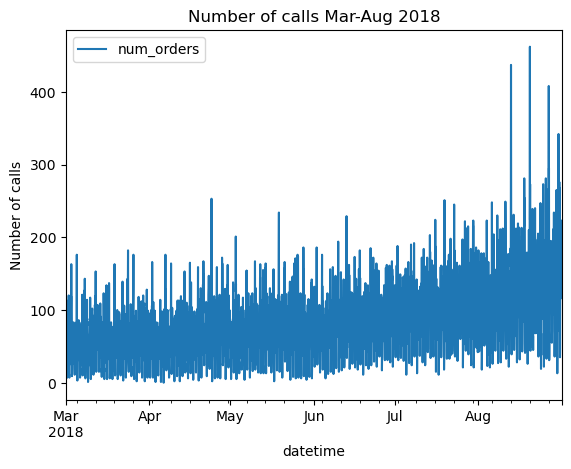

In [6]:
# display a graph based on the data
df.plot()
plt.title('Number of calls Mar-Aug 2018')
plt.ylabel('Number of calls');

In [7]:
# look for gaps in the data
df.isnull().mean()

num_orders    0.0
dtype: float64

We downloaded a dataset consisting of two columns and more than 26,000 rows. Changed the data type of the datetime column from object to datetime64. We carried out resampling, grouping the data for each hour. Data provided for six months of 2018 from March to August. There are no gaps in the data.

## Analysis

In [8]:
# display statistic information based on the data
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


The minimum number of calls is 0, which means that work does not always happen, the maximum is 462, such data is visible in the graph above (accounts for August), the average number is approximately 84.

In [9]:
# display the moving average on the chart
import matplotlib.pyplot as plt
def mplt (data, n):
    df_c = df.copy()
    df_c['rolling_mean'] = df_c.rolling(n).mean()
    df_c.plot()
    plt.ylabel('Кол-во вызовов')
    plt.title('Скользящее среднее \n window size = {}'.format(n))
    plt.show();        

Moving average, month


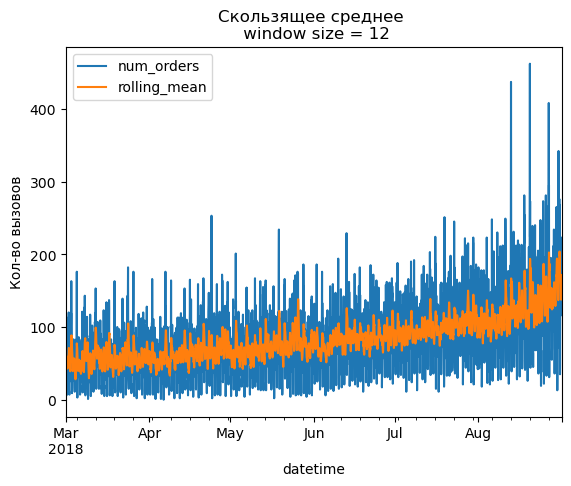

Moving average, day


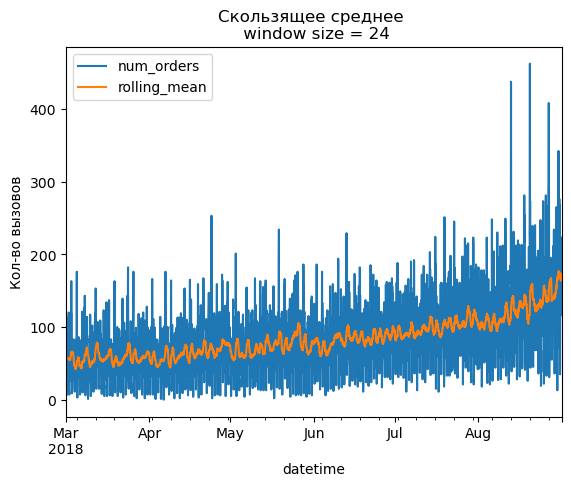

Moving average, week


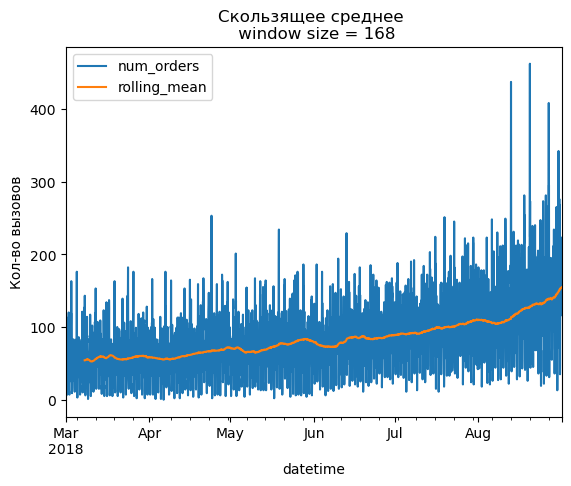

In [10]:
# display it on the screen
print('Moving average, month')
mplt(df, 12)
print('Moving average, day')
mplt(df, 24)
print('Moving average, week')
mplt(df, 24*7)

We smoothed out the time series data and thanks to this we see that there is an increase from month to month, the line went up more sharply in August.

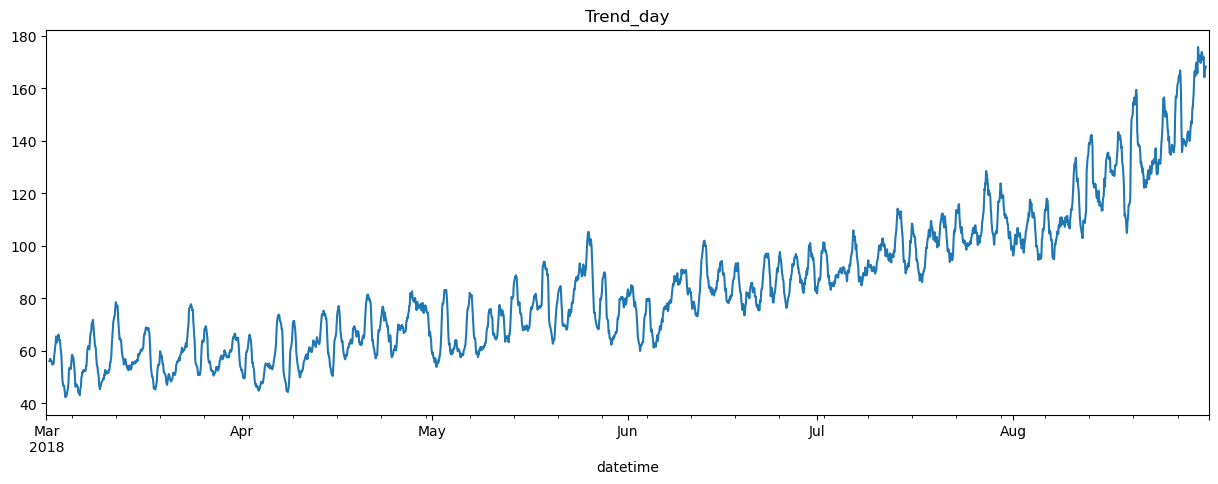

In [11]:
# дet's decompose the time series into a trend, a seasonal component 
## and the remainder of the decomposition
df_c2 = df.copy()
decomposed = seasonal_decompose(df_c2)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Trend_day');

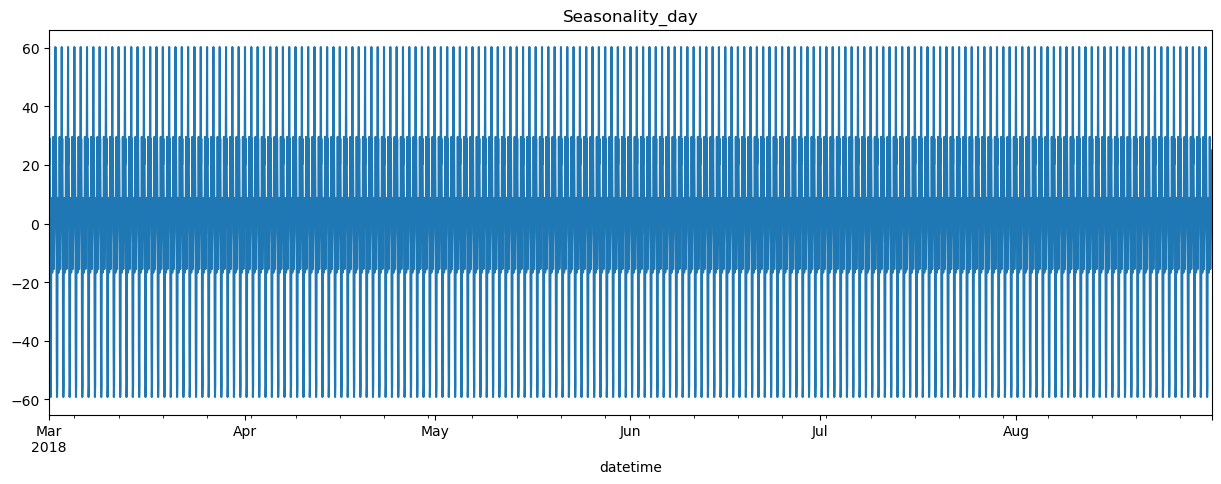

In [12]:
decomposed = seasonal_decompose(df_c2)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Seasonality_day');

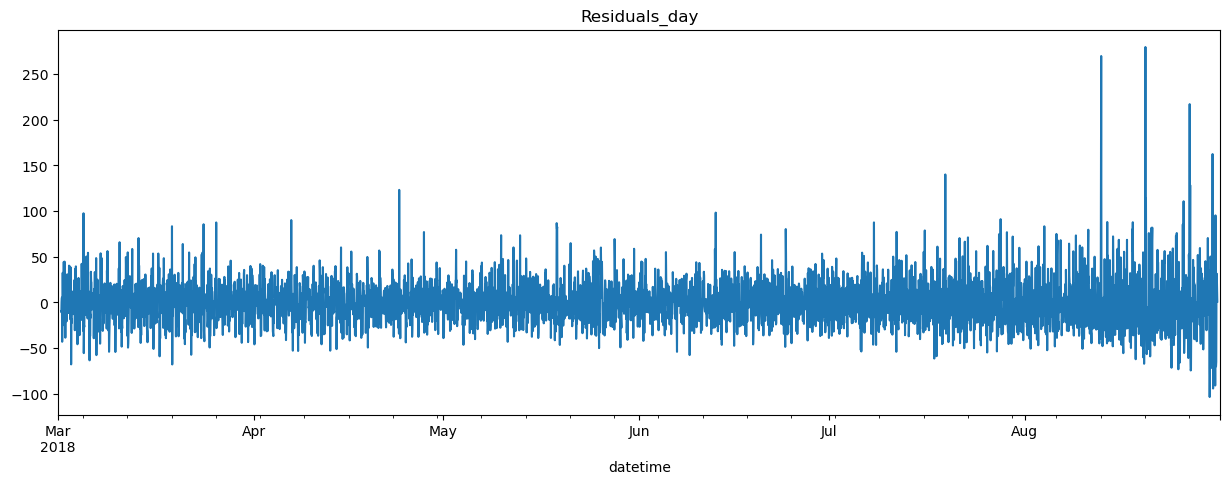

In [13]:
decomposed = seasonal_decompose(df_c2)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Residuals_day');

The chart shows that there is an upward trend. Nothing is clear from the seasonality chart.

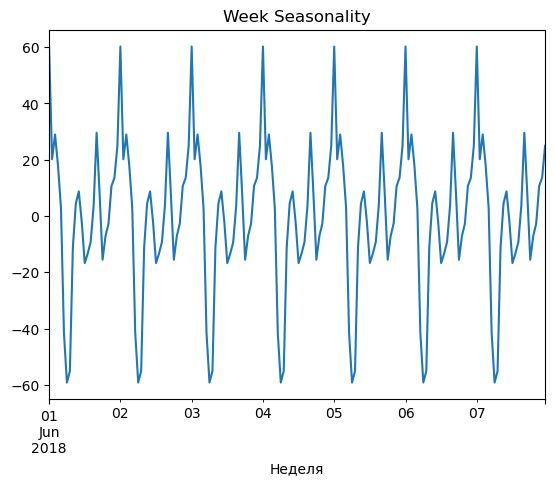

In [14]:
# let's look at the charts by week
decomposed.seasonal['2018-06-01':'2018-06-07'].plot()
plt.xlabel('Неделя')
plt.title('Week Seasonality');

We see that seasonality exists, there is a drop, perhaps in the early morning hours and a peak perhaps at night

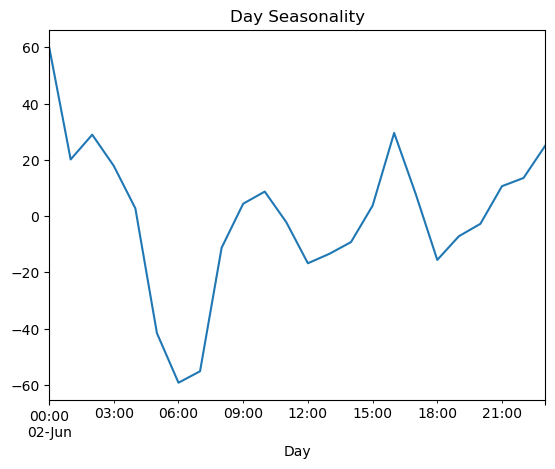

In [15]:
# let's look at the charts by day
decomposed.seasonal['2018-06-02':'2018-06-02'].plot()
plt.xlabel('Day')
plt.title('Day Seasonality')
del df_c2, decomposed;

In [16]:
# let's look at the weekly seasonality
# data resampling by day
df_c = df.copy()
df_c = df.resample('1D').sum()
df_c.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


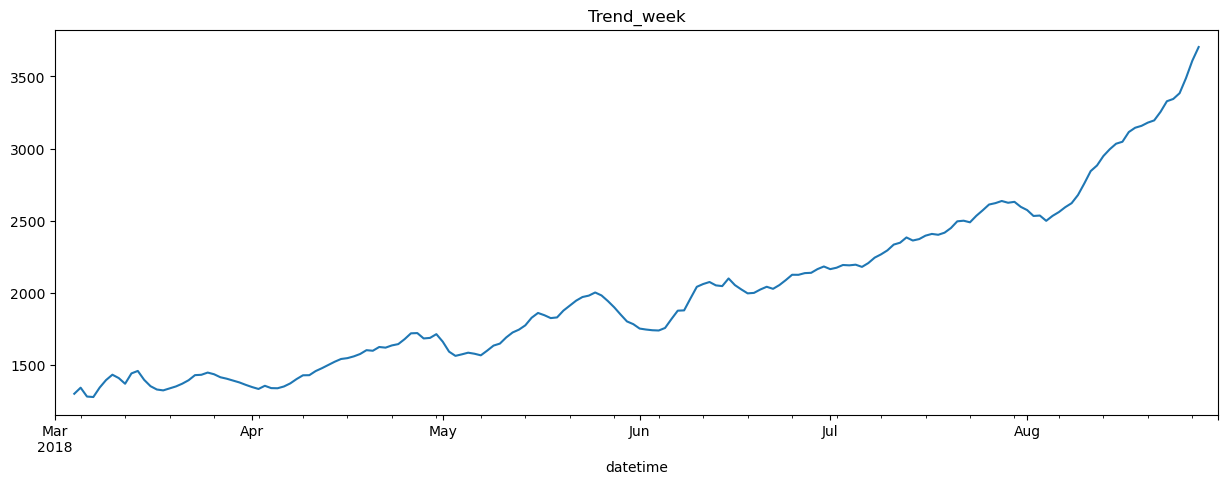

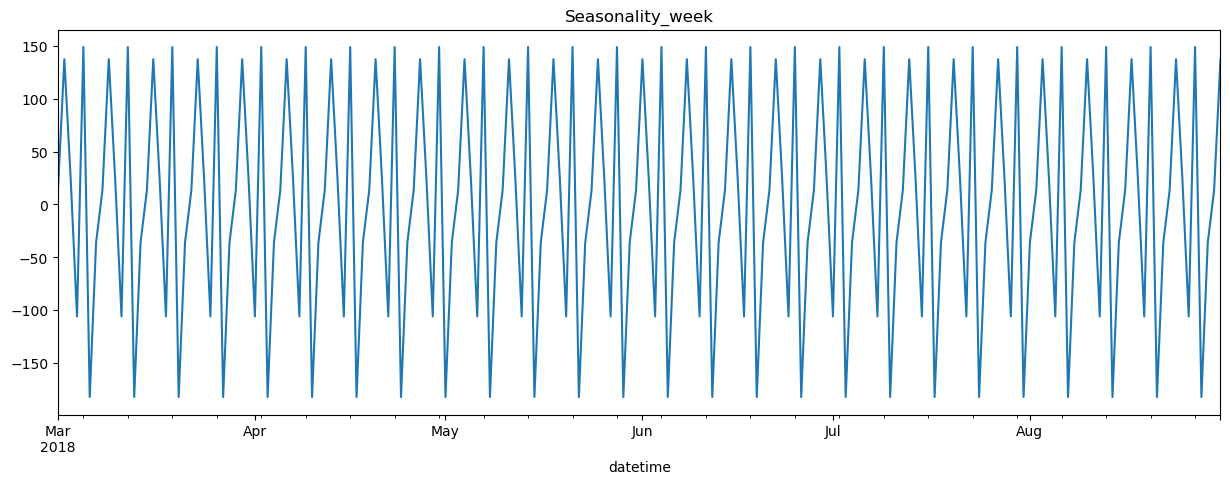

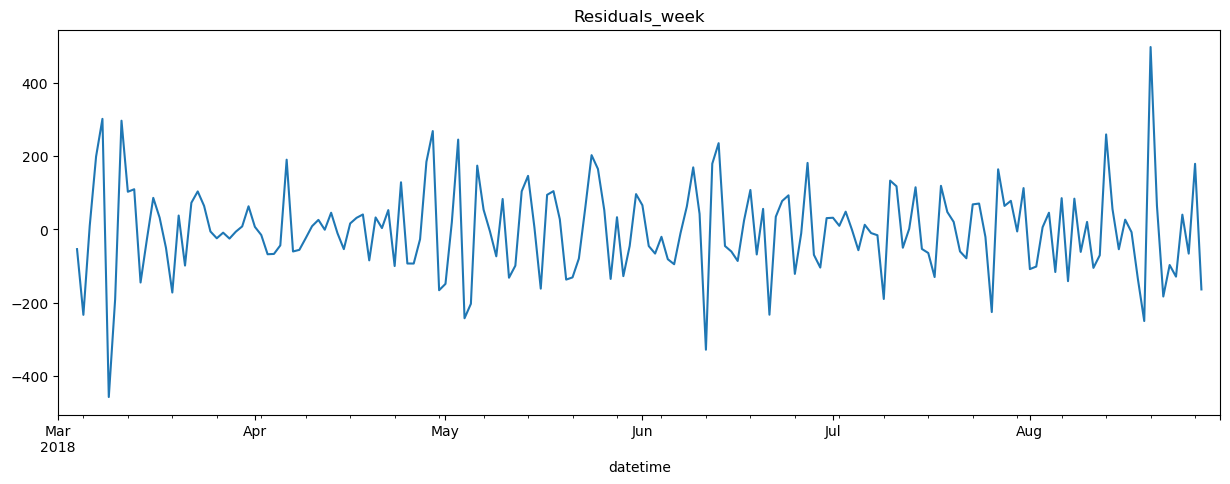

In [17]:
# let's decompose the time series into a trend, a seasonal component 
## and the remainder of the decomposition
decomposed = seasonal_decompose(df_c)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Trend_week')
plt.show();
# seasonal component
decomposed = seasonal_decompose(df_c)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Seasonality_week')
plt.show();
# decomposition remainder
decomposed = seasonal_decompose(df_c)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Residuals_week')
plt.show()
del df_c, decomposed;

In the context of one day, we observe a sharp drop in orders by 06:00 and a maximum peak of orders somewhere from 00:00. Also, having recapitulated the data by day and decomposed the data into a trend, a seasonal component, we see that on the Trend_week graph that the first week of each month there is a decrease in orders, in the second and third weeks there is an increase. But despite the chart going down in the first weeks, we still see a general upward trend from March to August

In [18]:
df_c3 = df.copy()
df_c3.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


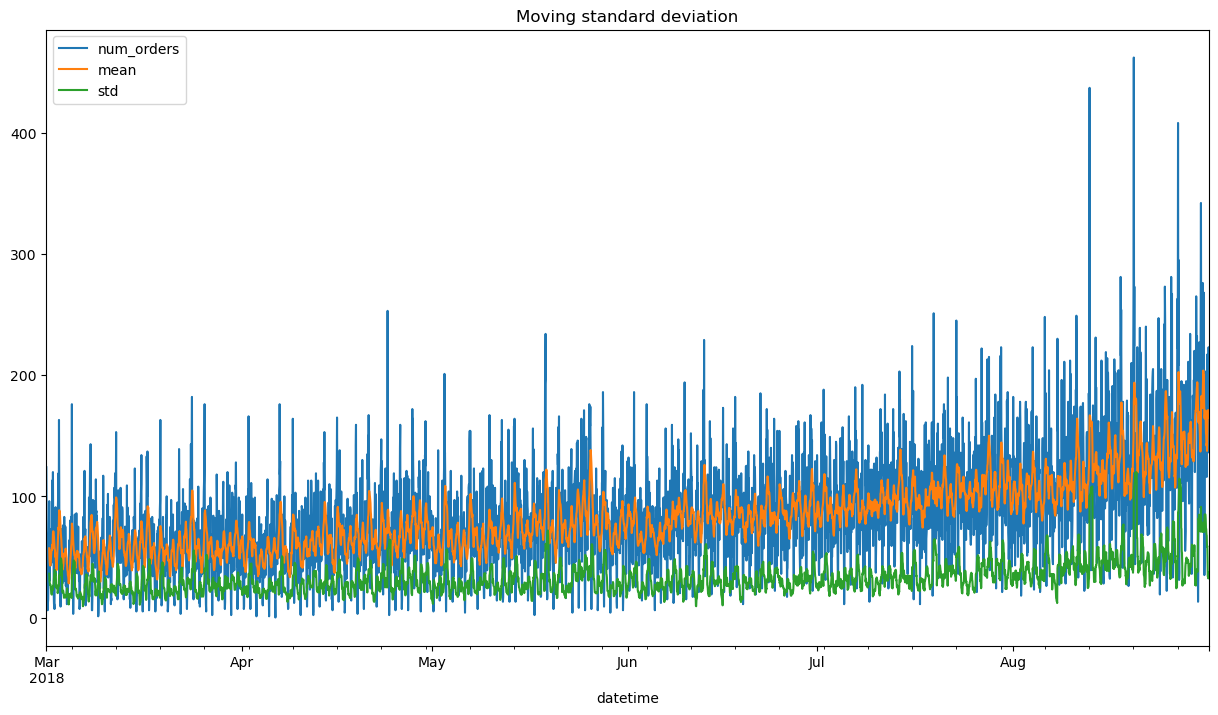

In [19]:
# stationarity of time series
df_c3['mean'] = df_c3['num_orders'].rolling(12).mean()
df_c3['std'] = df_c3['num_orders'].rolling(12).std()
df_c3.plot(figsize=(15,8), title='Moving standard deviation')
del df_c3;

In our analysis, we found that there is an upward trend from month to month. There is also daily seasonality, we see a drop from 03:00 to 06:00, the maximum peak occurs at 00:00, which starts from 18:00. The time series is non-stationary.

## Learning

### Preparing data for training

In [20]:
# let's create new features: day, day of week, hour, lags and moving average
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df
make_features(df, 24, 24 )

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [21]:
# divide into samples into train and test (10% of the original)
train, test = train_test_split(df, shuffle=False, test_size=.1)
# remove missing values in train
train = train.dropna()
# features and the target feature
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
# display sample sizes
print('Size of samples with features:',features_train.shape, features_test.shape)
print('Size of samples with target attribute:',target_train.shape, target_test.shape)

Size of samples with features: (3950, 28) (442, 28)
Size of samples with target attribute: (3950,) (442,)


### Learning LinearRegression

In [22]:
# let's write rmse
def rmse (target, predict):
    return (mean_squared_error(target, predict)**.5)
# create rmse_score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [23]:
# since the data has 9 months, we have 8 divisions
tscv = TimeSeriesSplit(n_splits=8)

In [24]:
%%time
start = time.time()

# train the model
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
# print rmse using cross-validation
lr_cv_results = pd.Series(cross_val_score(model_lr, features_train, target_train,
                                          cv=tscv, scoring = rmse_score)).mean()*(-1)

end = time.time()
eval_time_lr_l = end-start

print('RMSE LiearRegression:', lr_cv_results)

RMSE LiearRegression: 26.63400471459287
CPU times: total: 125 ms
Wall time: 92.2 ms


### Learning RandomForestRegressor

In [25]:
%%time
start = time.time()

# let's announce the model
model_rfr = RandomForestRegressor(random_state=42)

# let's write down the parameters
param_search = {'n_estimators': [10, 30, 5],
                'min_samples_leaf': range(1, 5),
                'max_depth' : [i for i in range(5,15)]}
gsearch_rfr = GridSearchCV(estimator=model_rfr, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch_rfr.fit(features_train, target_train)

best_score = gsearch_rfr.score(features_train, target_train) * (-1)
best_params = gsearch_rfr.best_params_

end = time.time()
eval_time_rfr_l = end-start

print('RMSE RandomForestRegressor:', best_score)
print('Best RandomForestRegressor params:', best_params)

RMSE RandomForestRegressor: 12.443623494138564
Best RandomForestRegressor params: {'max_depth': 14, 'min_samples_leaf': 3, 'n_estimators': 30}
CPU times: total: 13min 17s
Wall time: 13min 17s


### Learning CatBoostRegressor

In [26]:
%%time
start = time.time()

# let's announce the model
model_cbr = CatBoostRegressor()

# let's write down the parameters
param_search_cbr = {'n_estimators': [10, 30, 5],
                'learning_rate': [0.01, 0.4],
                'max_depth' : [i for i in range(5,15)]}

gsearch_cbr = GridSearchCV(estimator=model_cbr, cv=tscv, param_grid=param_search_cbr, scoring = rmse_score)
gsearch_cbr.fit(features_train, target_train)

best_score_cbr = gsearch_cbr.score(features_train, target_train) * (-1)
best_params_cbr = gsearch_cbr.best_params_

end = time.time()
eval_time_cbr_l = end-start

print('RMSE CatBoostRegressor:', best_score_cbr)
print('Best CatBoostRegressor params:', best_params_cbr)


0:	learn: 29.1189040	total: 149ms	remaining: 1.34s
1:	learn: 28.9944006	total: 151ms	remaining: 606ms
2:	learn: 28.8980791	total: 154ms	remaining: 359ms
3:	learn: 28.7906694	total: 157ms	remaining: 236ms
4:	learn: 28.6634526	total: 162ms	remaining: 162ms
5:	learn: 28.5539098	total: 164ms	remaining: 109ms
6:	learn: 28.4273384	total: 167ms	remaining: 71.6ms
7:	learn: 28.3011504	total: 169ms	remaining: 42.3ms
8:	learn: 28.1922505	total: 172ms	remaining: 19.1ms
9:	learn: 28.0765973	total: 174ms	remaining: 0us
0:	learn: 29.3534557	total: 3.35ms	remaining: 30.2ms
1:	learn: 29.2283596	total: 5.91ms	remaining: 23.7ms
2:	learn: 29.1086681	total: 8.46ms	remaining: 19.7ms
3:	learn: 28.9978430	total: 10.9ms	remaining: 16.4ms
4:	learn: 28.8630294	total: 13.4ms	remaining: 13.4ms
5:	learn: 28.7519857	total: 16.1ms	remaining: 10.7ms
6:	learn: 28.6255089	total: 18.6ms	remaining: 7.99ms
7:	learn: 28.4930423	total: 21.2ms	remaining: 5.29ms
8:	learn: 28.3627680	total: 23.7ms	remaining: 2.63ms
9:	learn: 28

14:	learn: 29.5541744	total: 47.3ms	remaining: 47.3ms
15:	learn: 29.4385987	total: 52.1ms	remaining: 45.6ms
16:	learn: 29.3236346	total: 55.6ms	remaining: 42.5ms
17:	learn: 29.2143312	total: 59.3ms	remaining: 39.5ms
18:	learn: 29.1052950	total: 63.1ms	remaining: 36.6ms
19:	learn: 28.9865516	total: 66.8ms	remaining: 33.4ms
20:	learn: 28.8648173	total: 71.2ms	remaining: 30.5ms
21:	learn: 28.7591343	total: 74.3ms	remaining: 27ms
22:	learn: 28.6494657	total: 77.2ms	remaining: 23.5ms
23:	learn: 28.5429742	total: 80.2ms	remaining: 20.1ms
24:	learn: 28.4450914	total: 84.3ms	remaining: 16.9ms
25:	learn: 28.3525210	total: 87.3ms	remaining: 13.4ms
26:	learn: 28.2542345	total: 90.4ms	remaining: 10ms
27:	learn: 28.1543023	total: 93.5ms	remaining: 6.68ms
28:	learn: 28.0513704	total: 96.6ms	remaining: 3.33ms
29:	learn: 27.9548168	total: 99.8ms	remaining: 0us
0:	learn: 32.8053698	total: 4.09ms	remaining: 119ms
1:	learn: 32.6737552	total: 7.4ms	remaining: 104ms
2:	learn: 32.5395603	total: 10.8ms	remai

0:	learn: 33.9709568	total: 10.2ms	remaining: 40.7ms
1:	learn: 33.8182965	total: 15.9ms	remaining: 23.9ms
2:	learn: 33.6694690	total: 21ms	remaining: 14ms
3:	learn: 33.5273452	total: 25.4ms	remaining: 6.35ms
4:	learn: 33.3804812	total: 29.1ms	remaining: 0us
0:	learn: 35.5793292	total: 4.84ms	remaining: 19.4ms
1:	learn: 35.4178346	total: 8.81ms	remaining: 13.2ms
2:	learn: 35.2615616	total: 12.7ms	remaining: 8.48ms
3:	learn: 35.1116107	total: 16.6ms	remaining: 4.16ms
4:	learn: 34.9624174	total: 20.5ms	remaining: 0us
0:	learn: 29.1180913	total: 4.32ms	remaining: 38.8ms
1:	learn: 28.9688494	total: 7.83ms	remaining: 31.3ms
2:	learn: 28.8151814	total: 11.5ms	remaining: 26.8ms
3:	learn: 28.6853534	total: 15.3ms	remaining: 23ms
4:	learn: 28.5511989	total: 19ms	remaining: 19ms
5:	learn: 28.4443764	total: 22.5ms	remaining: 15ms
6:	learn: 28.3321930	total: 26.1ms	remaining: 11.2ms
7:	learn: 28.2118893	total: 29.5ms	remaining: 7.37ms
8:	learn: 28.0965583	total: 32.9ms	remaining: 3.65ms
9:	learn: 2

21:	learn: 27.8898600	total: 102ms	remaining: 37.1ms
22:	learn: 27.7888735	total: 109ms	remaining: 33.1ms
23:	learn: 27.6961796	total: 114ms	remaining: 28.5ms
24:	learn: 27.5901578	total: 119ms	remaining: 23.9ms
25:	learn: 27.4830446	total: 125ms	remaining: 19.3ms
26:	learn: 27.3863141	total: 130ms	remaining: 14.4ms
27:	learn: 27.2974065	total: 134ms	remaining: 9.58ms
28:	learn: 27.1942961	total: 139ms	remaining: 4.79ms
29:	learn: 27.1027771	total: 143ms	remaining: 0us
0:	learn: 31.2646111	total: 5.31ms	remaining: 154ms
1:	learn: 31.1254294	total: 9.95ms	remaining: 139ms
2:	learn: 30.9857950	total: 14.7ms	remaining: 132ms
3:	learn: 30.8403408	total: 19.5ms	remaining: 127ms
4:	learn: 30.7067085	total: 24.3ms	remaining: 121ms
5:	learn: 30.5757180	total: 28.9ms	remaining: 115ms
6:	learn: 30.4481168	total: 33.7ms	remaining: 111ms
7:	learn: 30.3271863	total: 38.4ms	remaining: 106ms
8:	learn: 30.2124567	total: 43.1ms	remaining: 101ms
9:	learn: 30.0892639	total: 47.8ms	remaining: 95.7ms
10:	l

0:	learn: 29.3535284	total: 12ms	remaining: 48.1ms
1:	learn: 29.2179011	total: 19.2ms	remaining: 28.7ms
2:	learn: 29.0712210	total: 25.6ms	remaining: 17.1ms
3:	learn: 28.9286947	total: 30.5ms	remaining: 7.63ms
4:	learn: 28.7952791	total: 34.9ms	remaining: 0us
0:	learn: 30.3858076	total: 18ms	remaining: 71.8ms
1:	learn: 30.2486263	total: 26.1ms	remaining: 39.1ms
2:	learn: 30.1063077	total: 32.6ms	remaining: 21.8ms
3:	learn: 29.9794957	total: 37.9ms	remaining: 9.49ms
4:	learn: 29.8505399	total: 42.9ms	remaining: 0us
0:	learn: 31.2646111	total: 6.18ms	remaining: 24.7ms
1:	learn: 31.1254294	total: 11ms	remaining: 16.5ms
2:	learn: 30.9857950	total: 15.9ms	remaining: 10.6ms
3:	learn: 30.8403408	total: 21ms	remaining: 5.25ms
4:	learn: 30.7067085	total: 25.8ms	remaining: 0us
0:	learn: 32.8030681	total: 12ms	remaining: 48ms
1:	learn: 32.6514589	total: 19.7ms	remaining: 29.6ms
2:	learn: 32.5039398	total: 25.9ms	remaining: 17.3ms
3:	learn: 32.3515039	total: 31.4ms	remaining: 7.84ms
4:	learn: 32.2

29:	learn: 26.0283873	total: 213ms	remaining: 0us
0:	learn: 30.3785401	total: 8.35ms	remaining: 242ms
1:	learn: 30.2483582	total: 15.9ms	remaining: 222ms
2:	learn: 30.1132704	total: 23.1ms	remaining: 207ms
3:	learn: 29.9838779	total: 30.2ms	remaining: 196ms
4:	learn: 29.8584702	total: 37.8ms	remaining: 189ms
5:	learn: 29.7276616	total: 45.1ms	remaining: 180ms
6:	learn: 29.6036647	total: 52.7ms	remaining: 173ms
7:	learn: 29.4713310	total: 60.1ms	remaining: 165ms
8:	learn: 29.3481168	total: 67.8ms	remaining: 158ms
9:	learn: 29.2234194	total: 75.2ms	remaining: 150ms
10:	learn: 29.1104716	total: 82.3ms	remaining: 142ms
11:	learn: 28.9859161	total: 89.8ms	remaining: 135ms
12:	learn: 28.8664761	total: 97.2ms	remaining: 127ms
13:	learn: 28.7470603	total: 105ms	remaining: 120ms
14:	learn: 28.6284377	total: 112ms	remaining: 112ms
15:	learn: 28.5305532	total: 120ms	remaining: 105ms
16:	learn: 28.4274932	total: 128ms	remaining: 97.6ms
17:	learn: 28.3081479	total: 135ms	remaining: 90.2ms
18:	learn

8:	learn: 34.3537830	total: 100ms	remaining: 234ms
9:	learn: 34.1941200	total: 113ms	remaining: 226ms
10:	learn: 34.0487254	total: 125ms	remaining: 217ms
11:	learn: 33.8933896	total: 136ms	remaining: 204ms
12:	learn: 33.7618660	total: 146ms	remaining: 191ms
13:	learn: 33.6134583	total: 156ms	remaining: 178ms
14:	learn: 33.4652479	total: 166ms	remaining: 166ms
15:	learn: 33.3208507	total: 177ms	remaining: 154ms
16:	learn: 33.1849002	total: 186ms	remaining: 142ms
17:	learn: 33.0441909	total: 196ms	remaining: 131ms
18:	learn: 32.9149904	total: 206ms	remaining: 119ms
19:	learn: 32.7772738	total: 216ms	remaining: 108ms
20:	learn: 32.6418168	total: 226ms	remaining: 96.9ms
21:	learn: 32.5022807	total: 236ms	remaining: 85.8ms
22:	learn: 32.3642182	total: 246ms	remaining: 74.7ms
23:	learn: 32.2235656	total: 255ms	remaining: 63.8ms
24:	learn: 32.0932523	total: 265ms	remaining: 53.1ms
25:	learn: 31.9683001	total: 275ms	remaining: 42.4ms
26:	learn: 31.8443931	total: 285ms	remaining: 31.7ms
27:	lea

23:	learn: 26.5364206	total: 273ms	remaining: 68.3ms
24:	learn: 26.4321325	total: 288ms	remaining: 57.7ms
25:	learn: 26.3175431	total: 300ms	remaining: 46.1ms
26:	learn: 26.2248821	total: 310ms	remaining: 34.5ms
27:	learn: 26.1194156	total: 322ms	remaining: 23ms
28:	learn: 26.0356291	total: 333ms	remaining: 11.5ms
29:	learn: 25.9292340	total: 344ms	remaining: 0us
0:	learn: 29.3439987	total: 20.7ms	remaining: 599ms
1:	learn: 29.2160584	total: 33.8ms	remaining: 473ms
2:	learn: 29.0960967	total: 46.8ms	remaining: 421ms
3:	learn: 28.9637190	total: 59.2ms	remaining: 385ms
4:	learn: 28.8411461	total: 71.7ms	remaining: 358ms
5:	learn: 28.7031350	total: 83.5ms	remaining: 334ms
6:	learn: 28.5745679	total: 97.9ms	remaining: 322ms
7:	learn: 28.4492355	total: 112ms	remaining: 309ms
8:	learn: 28.3359965	total: 125ms	remaining: 291ms
9:	learn: 28.2191559	total: 138ms	remaining: 275ms
10:	learn: 28.1110706	total: 150ms	remaining: 259ms
11:	learn: 28.0029184	total: 162ms	remaining: 243ms
12:	learn: 27

12:	learn: 32.1577304	total: 227ms	remaining: 296ms
13:	learn: 32.0173751	total: 248ms	remaining: 283ms
14:	learn: 31.8769770	total: 267ms	remaining: 267ms
15:	learn: 31.7446162	total: 285ms	remaining: 250ms
16:	learn: 31.6175038	total: 303ms	remaining: 232ms
17:	learn: 31.4856431	total: 320ms	remaining: 213ms
18:	learn: 31.3547928	total: 337ms	remaining: 195ms
19:	learn: 31.2310797	total: 354ms	remaining: 177ms
20:	learn: 31.1027253	total: 371ms	remaining: 159ms
21:	learn: 30.9826434	total: 387ms	remaining: 141ms
22:	learn: 30.8563498	total: 404ms	remaining: 123ms
23:	learn: 30.7307198	total: 422ms	remaining: 105ms
24:	learn: 30.6181151	total: 439ms	remaining: 87.7ms
25:	learn: 30.5048757	total: 460ms	remaining: 70.8ms
26:	learn: 30.3743279	total: 477ms	remaining: 53ms
27:	learn: 30.2645006	total: 494ms	remaining: 35.3ms
28:	learn: 30.1578245	total: 510ms	remaining: 17.6ms
29:	learn: 30.0410800	total: 527ms	remaining: 0us
0:	learn: 35.5633291	total: 19.7ms	remaining: 572ms
1:	learn: 3

6:	learn: 34.5964393	total: 263ms	remaining: 113ms
7:	learn: 34.4353464	total: 302ms	remaining: 75.5ms
8:	learn: 34.2813877	total: 336ms	remaining: 37.3ms
9:	learn: 34.1305423	total: 371ms	remaining: 0us
0:	learn: 29.1013216	total: 23.8ms	remaining: 690ms
1:	learn: 28.9923419	total: 44.1ms	remaining: 618ms
2:	learn: 28.8789399	total: 67.5ms	remaining: 607ms
3:	learn: 28.7725587	total: 91.4ms	remaining: 594ms
4:	learn: 28.6677912	total: 112ms	remaining: 562ms
5:	learn: 28.5576631	total: 135ms	remaining: 539ms
6:	learn: 28.4257857	total: 156ms	remaining: 511ms
7:	learn: 28.3163960	total: 177ms	remaining: 486ms
8:	learn: 28.1836081	total: 197ms	remaining: 460ms
9:	learn: 28.0493442	total: 218ms	remaining: 436ms
10:	learn: 27.9237472	total: 238ms	remaining: 410ms
11:	learn: 27.7998380	total: 259ms	remaining: 388ms
12:	learn: 27.6972018	total: 279ms	remaining: 365ms
13:	learn: 27.5914149	total: 305ms	remaining: 348ms
14:	learn: 27.4774172	total: 327ms	remaining: 327ms
15:	learn: 27.3617209	

11:	learn: 31.6675181	total: 387ms	remaining: 580ms
12:	learn: 31.5361516	total: 420ms	remaining: 549ms
13:	learn: 31.4006814	total: 452ms	remaining: 516ms
14:	learn: 31.2702054	total: 484ms	remaining: 484ms
15:	learn: 31.1433367	total: 516ms	remaining: 451ms
16:	learn: 31.0172702	total: 545ms	remaining: 417ms
17:	learn: 30.8833797	total: 576ms	remaining: 384ms
18:	learn: 30.7541551	total: 609ms	remaining: 352ms
19:	learn: 30.6244418	total: 642ms	remaining: 321ms
20:	learn: 30.5003229	total: 673ms	remaining: 289ms
21:	learn: 30.3752733	total: 704ms	remaining: 256ms
22:	learn: 30.2505452	total: 736ms	remaining: 224ms
23:	learn: 30.1241895	total: 767ms	remaining: 192ms
24:	learn: 29.9985405	total: 798ms	remaining: 160ms
25:	learn: 29.8761026	total: 833ms	remaining: 128ms
26:	learn: 29.7526262	total: 867ms	remaining: 96.4ms
27:	learn: 29.6260022	total: 899ms	remaining: 64.2ms
28:	learn: 29.5075366	total: 932ms	remaining: 32.1ms
29:	learn: 29.3911857	total: 964ms	remaining: 0us
0:	learn: 3

1:	learn: 32.6652527	total: 141ms	remaining: 566ms
2:	learn: 32.5218253	total: 221ms	remaining: 516ms
3:	learn: 32.3767411	total: 293ms	remaining: 440ms
4:	learn: 32.2357010	total: 368ms	remaining: 368ms
5:	learn: 32.0920890	total: 442ms	remaining: 294ms
6:	learn: 31.9496109	total: 515ms	remaining: 221ms
7:	learn: 31.8194539	total: 590ms	remaining: 147ms
8:	learn: 31.6778813	total: 667ms	remaining: 74.1ms
9:	learn: 31.5285961	total: 736ms	remaining: 0us
0:	learn: 33.2167867	total: 71.9ms	remaining: 647ms
1:	learn: 33.0722608	total: 147ms	remaining: 587ms
2:	learn: 32.9235614	total: 223ms	remaining: 520ms
3:	learn: 32.7786687	total: 301ms	remaining: 451ms
4:	learn: 32.6381312	total: 378ms	remaining: 378ms
5:	learn: 32.5029170	total: 452ms	remaining: 302ms
6:	learn: 32.3677343	total: 531ms	remaining: 227ms
7:	learn: 32.2205508	total: 611ms	remaining: 153ms
8:	learn: 32.0787048	total: 686ms	remaining: 76.2ms
9:	learn: 31.9263390	total: 761ms	remaining: 0us
0:	learn: 33.9607794	total: 82.6

1:	learn: 32.6652527	total: 143ms	remaining: 2s
2:	learn: 32.5218253	total: 216ms	remaining: 1.95s
3:	learn: 32.3767411	total: 288ms	remaining: 1.87s
4:	learn: 32.2357010	total: 364ms	remaining: 1.82s
5:	learn: 32.0920890	total: 443ms	remaining: 1.77s
6:	learn: 31.9496109	total: 516ms	remaining: 1.7s
7:	learn: 31.8194539	total: 592ms	remaining: 1.63s
8:	learn: 31.6778813	total: 665ms	remaining: 1.55s
9:	learn: 31.5285961	total: 742ms	remaining: 1.48s
10:	learn: 31.3725816	total: 815ms	remaining: 1.41s
11:	learn: 31.2255210	total: 891ms	remaining: 1.34s
12:	learn: 31.1054261	total: 964ms	remaining: 1.26s
13:	learn: 30.9691500	total: 1.04s	remaining: 1.19s
14:	learn: 30.8498018	total: 1.11s	remaining: 1.11s
15:	learn: 30.7316427	total: 1.18s	remaining: 1.03s
16:	learn: 30.6032701	total: 1.26s	remaining: 961ms
17:	learn: 30.4860231	total: 1.33s	remaining: 887ms
18:	learn: 30.3545455	total: 1.4s	remaining: 813ms
19:	learn: 30.2252265	total: 1.48s	remaining: 740ms
20:	learn: 30.1109312	tota

3:	learn: 28.7870747	total: 313ms	remaining: 469ms
4:	learn: 28.6577390	total: 423ms	remaining: 423ms
5:	learn: 28.5274086	total: 518ms	remaining: 345ms
6:	learn: 28.4315081	total: 617ms	remaining: 265ms
7:	learn: 28.3165195	total: 717ms	remaining: 179ms
8:	learn: 28.1982212	total: 818ms	remaining: 90.8ms
9:	learn: 28.0995959	total: 915ms	remaining: 0us
0:	learn: 29.3448683	total: 129ms	remaining: 1.16s
1:	learn: 29.2386661	total: 247ms	remaining: 988ms
2:	learn: 29.1395290	total: 369ms	remaining: 861ms
3:	learn: 29.0194094	total: 483ms	remaining: 724ms
4:	learn: 28.8985973	total: 608ms	remaining: 608ms
5:	learn: 28.7837047	total: 724ms	remaining: 483ms
6:	learn: 28.6614527	total: 846ms	remaining: 362ms
7:	learn: 28.5330335	total: 962ms	remaining: 241ms
8:	learn: 28.4025504	total: 1.09s	remaining: 121ms
9:	learn: 28.3127288	total: 1.21s	remaining: 0us
0:	learn: 30.3825014	total: 128ms	remaining: 1.15s
1:	learn: 30.2625834	total: 254ms	remaining: 1.02s
2:	learn: 30.1452247	total: 387ms	

24:	learn: 27.6131325	total: 3.31s	remaining: 663ms
25:	learn: 27.5026383	total: 3.44s	remaining: 529ms
26:	learn: 27.4072245	total: 3.57s	remaining: 396ms
27:	learn: 27.2867159	total: 3.69s	remaining: 264ms
28:	learn: 27.1842377	total: 3.82s	remaining: 132ms
29:	learn: 27.0905595	total: 3.95s	remaining: 0us
0:	learn: 31.2629780	total: 143ms	remaining: 4.14s
1:	learn: 31.1480572	total: 285ms	remaining: 3.98s
2:	learn: 31.0129344	total: 418ms	remaining: 3.76s
3:	learn: 30.8897076	total: 546ms	remaining: 3.55s
4:	learn: 30.7557051	total: 681ms	remaining: 3.4s
5:	learn: 30.6449523	total: 817ms	remaining: 3.27s
6:	learn: 30.5219222	total: 960ms	remaining: 3.15s
7:	learn: 30.3851550	total: 1.1s	remaining: 3.02s
8:	learn: 30.2659213	total: 1.24s	remaining: 2.88s
9:	learn: 30.1589150	total: 1.38s	remaining: 2.75s
10:	learn: 30.0313511	total: 1.51s	remaining: 2.61s
11:	learn: 29.9017591	total: 1.65s	remaining: 2.47s
12:	learn: 29.7724306	total: 1.78s	remaining: 2.33s
13:	learn: 29.6516886	tota

4:	learn: 28.6577390	total: 430ms	remaining: 0us
0:	learn: 29.3448683	total: 133ms	remaining: 533ms
1:	learn: 29.2386661	total: 275ms	remaining: 412ms
2:	learn: 29.1395290	total: 395ms	remaining: 263ms
3:	learn: 29.0194094	total: 522ms	remaining: 130ms
4:	learn: 28.8985973	total: 645ms	remaining: 0us
0:	learn: 30.3825014	total: 123ms	remaining: 492ms
1:	learn: 30.2625834	total: 252ms	remaining: 379ms
2:	learn: 30.1452247	total: 386ms	remaining: 257ms
3:	learn: 30.0133915	total: 516ms	remaining: 129ms
4:	learn: 29.9029281	total: 648ms	remaining: 0us
0:	learn: 31.2629780	total: 141ms	remaining: 563ms
1:	learn: 31.1480572	total: 283ms	remaining: 424ms
2:	learn: 31.0129344	total: 417ms	remaining: 278ms
3:	learn: 30.8897076	total: 555ms	remaining: 139ms
4:	learn: 30.7557051	total: 689ms	remaining: 0us
0:	learn: 32.8079447	total: 166ms	remaining: 662ms
1:	learn: 32.6630089	total: 321ms	remaining: 482ms
2:	learn: 32.5322991	total: 477ms	remaining: 318ms
3:	learn: 32.3796932	total: 623ms	remai

16:	learn: 27.5223637	total: 4.14s	remaining: 3.17s
17:	learn: 27.4014935	total: 4.38s	remaining: 2.92s
18:	learn: 27.3093948	total: 4.62s	remaining: 2.68s
19:	learn: 27.2120081	total: 4.87s	remaining: 2.43s
20:	learn: 27.1071104	total: 5.11s	remaining: 2.19s
21:	learn: 27.0132919	total: 5.34s	remaining: 1.94s
22:	learn: 26.9027192	total: 5.58s	remaining: 1.7s
23:	learn: 26.8086637	total: 5.82s	remaining: 1.45s
24:	learn: 26.7141787	total: 6.07s	remaining: 1.21s
25:	learn: 26.6096095	total: 6.3s	remaining: 969ms
26:	learn: 26.4867841	total: 6.55s	remaining: 727ms
27:	learn: 26.3917982	total: 6.78s	remaining: 485ms
28:	learn: 26.2957778	total: 7.03s	remaining: 242ms
29:	learn: 26.1741292	total: 7.29s	remaining: 0us
0:	learn: 30.3864228	total: 244ms	remaining: 7.07s
1:	learn: 30.2560233	total: 506ms	remaining: 7.09s
2:	learn: 30.1207766	total: 763ms	remaining: 6.87s
3:	learn: 30.0149521	total: 1.03s	remaining: 6.69s
4:	learn: 29.8971176	total: 1.28s	remaining: 6.4s
5:	learn: 29.7727842	t

26:	learn: 30.4097634	total: 8.52s	remaining: 947ms
27:	learn: 30.2964510	total: 8.83s	remaining: 631ms
28:	learn: 30.1634678	total: 9.14s	remaining: 315ms
29:	learn: 30.0432877	total: 9.46s	remaining: 0us
0:	learn: 35.5608350	total: 338ms	remaining: 9.81s
1:	learn: 35.3985536	total: 680ms	remaining: 9.52s
2:	learn: 35.2295162	total: 1.01s	remaining: 9.14s
3:	learn: 35.0762137	total: 1.35s	remaining: 8.75s
4:	learn: 34.9186710	total: 1.69s	remaining: 8.43s
5:	learn: 34.7729839	total: 2.02s	remaining: 8.08s
6:	learn: 34.6234115	total: 2.34s	remaining: 7.69s
7:	learn: 34.4585780	total: 2.66s	remaining: 7.33s
8:	learn: 34.2978734	total: 2.99s	remaining: 6.98s
9:	learn: 34.1476771	total: 3.33s	remaining: 6.65s
10:	learn: 33.9938273	total: 3.66s	remaining: 6.33s
11:	learn: 33.8440816	total: 4s	remaining: 6.01s
12:	learn: 33.7017399	total: 4.33s	remaining: 5.66s
13:	learn: 33.5467894	total: 4.65s	remaining: 5.31s
14:	learn: 33.4091650	total: 4.98s	remaining: 4.98s
15:	learn: 33.2630500	total

8:	learn: 28.3416926	total: 3.61s	remaining: 8.43s
9:	learn: 28.2653924	total: 4.02s	remaining: 8.05s
10:	learn: 28.1541270	total: 4.42s	remaining: 7.64s
11:	learn: 28.0493508	total: 4.82s	remaining: 7.22s
12:	learn: 27.9577836	total: 5.22s	remaining: 6.82s
13:	learn: 27.8642203	total: 5.59s	remaining: 6.39s
14:	learn: 27.7681958	total: 5.99s	remaining: 5.99s
15:	learn: 27.6953297	total: 6.39s	remaining: 5.59s
16:	learn: 27.5765868	total: 6.8s	remaining: 5.2s
17:	learn: 27.4870510	total: 7.2s	remaining: 4.8s
18:	learn: 27.3997308	total: 7.59s	remaining: 4.39s
19:	learn: 27.3012016	total: 7.99s	remaining: 4s
20:	learn: 27.2105420	total: 8.39s	remaining: 3.59s
21:	learn: 27.1021205	total: 8.8s	remaining: 3.2s
22:	learn: 27.0162330	total: 9.2s	remaining: 2.8s
23:	learn: 26.9002633	total: 9.6s	remaining: 2.4s
24:	learn: 26.7767856	total: 10s	remaining: 2s
25:	learn: 26.6735879	total: 10.4s	remaining: 1.6s
26:	learn: 26.5798220	total: 10.8s	remaining: 1.2s
27:	learn: 26.4878468	total: 11.2s

18:	learn: 30.8547585	total: 11.5s	remaining: 6.68s
19:	learn: 30.7223543	total: 12.2s	remaining: 6.08s
20:	learn: 30.6013406	total: 12.8s	remaining: 5.48s
21:	learn: 30.4812029	total: 13.4s	remaining: 4.87s
22:	learn: 30.3732378	total: 14s	remaining: 4.26s
23:	learn: 30.2568477	total: 14.6s	remaining: 3.65s
24:	learn: 30.1265864	total: 15.2s	remaining: 3.04s
25:	learn: 30.0289498	total: 15.8s	remaining: 2.43s
26:	learn: 29.9113478	total: 16.4s	remaining: 1.82s
27:	learn: 29.7992080	total: 17s	remaining: 1.22s
28:	learn: 29.6879436	total: 17.6s	remaining: 608ms
29:	learn: 29.5664973	total: 18.2s	remaining: 0us
0:	learn: 33.9660268	total: 632ms	remaining: 18.3s
1:	learn: 33.8234909	total: 1.25s	remaining: 17.5s
2:	learn: 33.6831730	total: 1.9s	remaining: 17.1s
3:	learn: 33.5355900	total: 2.51s	remaining: 16.3s
4:	learn: 33.4013848	total: 3.13s	remaining: 15.6s
5:	learn: 33.2520762	total: 3.74s	remaining: 15s
6:	learn: 33.1115685	total: 4.35s	remaining: 14.3s
7:	learn: 32.9776768	total: 

9:	learn: 31.6568711	total: 11.5s	remaining: 0us
0:	learn: 33.2142854	total: 1.18s	remaining: 10.6s
1:	learn: 33.0905218	total: 2.35s	remaining: 9.42s
2:	learn: 32.9562316	total: 3.54s	remaining: 8.25s
3:	learn: 32.8292876	total: 4.71s	remaining: 7.07s
4:	learn: 32.6807069	total: 5.91s	remaining: 5.91s
5:	learn: 32.5584659	total: 7.1s	remaining: 4.73s
6:	learn: 32.4337739	total: 8.27s	remaining: 3.54s
7:	learn: 32.3077690	total: 9.45s	remaining: 2.36s
8:	learn: 32.1757379	total: 10.6s	remaining: 1.18s
9:	learn: 32.0409296	total: 11.8s	remaining: 0us
0:	learn: 33.9723099	total: 1.21s	remaining: 10.9s
1:	learn: 33.8324724	total: 2.44s	remaining: 9.77s
2:	learn: 33.6969758	total: 3.64s	remaining: 8.48s
3:	learn: 33.5765205	total: 4.84s	remaining: 7.26s
4:	learn: 33.4235119	total: 6.02s	remaining: 6.02s
5:	learn: 33.2994723	total: 7.2s	remaining: 4.8s
6:	learn: 33.1739536	total: 8.44s	remaining: 3.62s
7:	learn: 33.0407870	total: 9.62s	remaining: 2.4s
8:	learn: 32.9031384	total: 10.8s	remai

10:	learn: 31.5143475	total: 12.7s	remaining: 21.9s
11:	learn: 31.3962286	total: 13.8s	remaining: 20.7s
12:	learn: 31.2600576	total: 15s	remaining: 19.6s
13:	learn: 31.1524727	total: 16.1s	remaining: 18.4s
14:	learn: 31.0268457	total: 17.2s	remaining: 17.2s
15:	learn: 30.9117373	total: 18.4s	remaining: 16.1s
16:	learn: 30.7916075	total: 19.5s	remaining: 14.9s
17:	learn: 30.6658332	total: 20.6s	remaining: 13.8s
18:	learn: 30.5458211	total: 21.8s	remaining: 12.6s
19:	learn: 30.4158377	total: 23s	remaining: 11.5s
20:	learn: 30.3065386	total: 24.1s	remaining: 10.3s
21:	learn: 30.1897805	total: 25.3s	remaining: 9.19s
22:	learn: 30.0602614	total: 26.5s	remaining: 8.05s
23:	learn: 29.9673124	total: 27.6s	remaining: 6.91s
24:	learn: 29.8578660	total: 28.8s	remaining: 5.76s
25:	learn: 29.7462571	total: 30s	remaining: 4.61s
26:	learn: 29.6464087	total: 31.2s	remaining: 3.46s
27:	learn: 29.5445083	total: 32.3s	remaining: 2.31s
28:	learn: 29.4503397	total: 33.5s	remaining: 1.15s
29:	learn: 29.3316

0:	learn: 26.4091306	total: 10.1ms	remaining: 90.7ms
1:	learn: 23.4008604	total: 15.4ms	remaining: 61.7ms
2:	learn: 21.7533246	total: 20.4ms	remaining: 47.5ms
3:	learn: 20.7861012	total: 24.2ms	remaining: 36.2ms
4:	learn: 20.1760411	total: 27.9ms	remaining: 27.9ms
5:	learn: 19.3523690	total: 32.2ms	remaining: 21.4ms
6:	learn: 18.8821062	total: 39.3ms	remaining: 16.8ms
7:	learn: 18.4689361	total: 43.2ms	remaining: 10.8ms
8:	learn: 18.0486297	total: 46.9ms	remaining: 5.21ms
9:	learn: 17.6572723	total: 51ms	remaining: 0us
0:	learn: 26.2898228	total: 3.82ms	remaining: 34.4ms
1:	learn: 23.8762131	total: 6.88ms	remaining: 27.5ms
2:	learn: 22.3095132	total: 9.88ms	remaining: 23.1ms
3:	learn: 21.3914405	total: 13ms	remaining: 19.5ms
4:	learn: 20.6269699	total: 16ms	remaining: 16ms
5:	learn: 20.1534856	total: 19.1ms	remaining: 12.7ms
6:	learn: 19.6320863	total: 22.3ms	remaining: 9.57ms
7:	learn: 19.2589789	total: 25.6ms	remaining: 6.39ms
8:	learn: 18.9459046	total: 28.7ms	remaining: 3.18ms
9:	l

16:	learn: 18.3541514	total: 57.8ms	remaining: 44.2ms
17:	learn: 18.1660088	total: 62.6ms	remaining: 41.8ms
18:	learn: 18.0580531	total: 66.7ms	remaining: 38.6ms
19:	learn: 17.7976927	total: 70.7ms	remaining: 35.3ms
20:	learn: 17.5083976	total: 74.9ms	remaining: 32.1ms
21:	learn: 17.4721864	total: 79.7ms	remaining: 29ms
22:	learn: 17.2133662	total: 83.7ms	remaining: 25.5ms
23:	learn: 17.0710327	total: 87.1ms	remaining: 21.8ms
24:	learn: 16.9570084	total: 90.3ms	remaining: 18.1ms
25:	learn: 16.7485582	total: 93.6ms	remaining: 14.4ms
26:	learn: 16.4594903	total: 97ms	remaining: 10.8ms
27:	learn: 16.3453126	total: 101ms	remaining: 7.22ms
28:	learn: 16.3313629	total: 104ms	remaining: 3.6ms
29:	learn: 16.1992385	total: 108ms	remaining: 0us
0:	learn: 28.1996275	total: 4.29ms	remaining: 124ms
1:	learn: 25.2153254	total: 7.83ms	remaining: 110ms
2:	learn: 23.5355204	total: 11.6ms	remaining: 105ms
3:	learn: 22.5107890	total: 15.2ms	remaining: 98.8ms
4:	learn: 21.7827425	total: 18.7ms	remaining: 

7:	learn: 17.8574433	total: 37ms	remaining: 9.25ms
8:	learn: 17.5171013	total: 43.3ms	remaining: 4.81ms
9:	learn: 17.3406096	total: 48.8ms	remaining: 0us
0:	learn: 26.2516732	total: 6.09ms	remaining: 54.8ms
1:	learn: 23.1989488	total: 11.2ms	remaining: 44.6ms
2:	learn: 21.4188013	total: 16.2ms	remaining: 37.8ms
3:	learn: 20.3462725	total: 21.4ms	remaining: 32.1ms
4:	learn: 19.7517319	total: 26ms	remaining: 26ms
5:	learn: 19.2717340	total: 30.8ms	remaining: 20.6ms
6:	learn: 18.7865198	total: 35.5ms	remaining: 15.2ms
7:	learn: 18.4606337	total: 40.3ms	remaining: 10.1ms
8:	learn: 18.1114088	total: 45.1ms	remaining: 5.01ms
9:	learn: 17.8556124	total: 49.8ms	remaining: 0us
0:	learn: 27.3041416	total: 6ms	remaining: 54ms
1:	learn: 24.1079341	total: 11.1ms	remaining: 44.4ms
2:	learn: 22.4996514	total: 16.3ms	remaining: 38ms
3:	learn: 21.5925742	total: 21.7ms	remaining: 32.6ms
4:	learn: 20.8971228	total: 27.2ms	remaining: 27.2ms
5:	learn: 20.3207874	total: 32.4ms	remaining: 21.6ms
6:	learn: 19

13:	learn: 16.8174049	total: 77.9ms	remaining: 89.1ms
14:	learn: 16.6490187	total: 84.1ms	remaining: 84.1ms
15:	learn: 16.4088063	total: 90ms	remaining: 78.7ms
16:	learn: 16.2169715	total: 95.7ms	remaining: 73.2ms
17:	learn: 16.0305924	total: 101ms	remaining: 67.4ms
18:	learn: 15.8549932	total: 106ms	remaining: 61.3ms
19:	learn: 15.5182120	total: 111ms	remaining: 55.3ms
20:	learn: 15.3289749	total: 116ms	remaining: 49.6ms
21:	learn: 15.3087946	total: 121ms	remaining: 44ms
22:	learn: 15.2062753	total: 126ms	remaining: 38.3ms
23:	learn: 15.1825031	total: 131ms	remaining: 32.7ms
24:	learn: 14.9506108	total: 136ms	remaining: 27.1ms
25:	learn: 14.9300985	total: 140ms	remaining: 21.5ms
26:	learn: 14.7710302	total: 145ms	remaining: 16.1ms
27:	learn: 14.5835050	total: 150ms	remaining: 10.7ms
28:	learn: 14.5649572	total: 154ms	remaining: 5.32ms
29:	learn: 14.3796415	total: 159ms	remaining: 0us
0:	learn: 27.3041416	total: 6.24ms	remaining: 181ms
1:	learn: 24.1079341	total: 11.3ms	remaining: 158m

2:	learn: 22.4996514	total: 18.8ms	remaining: 12.5ms
3:	learn: 21.5925742	total: 25.5ms	remaining: 6.38ms
4:	learn: 20.8971228	total: 32.3ms	remaining: 0us
0:	learn: 28.1965298	total: 7.83ms	remaining: 31.3ms
1:	learn: 24.6739926	total: 13.2ms	remaining: 19.8ms
2:	learn: 22.9501095	total: 18.7ms	remaining: 12.5ms
3:	learn: 21.8915721	total: 24.1ms	remaining: 6.02ms
4:	learn: 21.3147938	total: 29.5ms	remaining: 0us
0:	learn: 28.6584842	total: 6.66ms	remaining: 26.6ms
1:	learn: 25.1737757	total: 12.3ms	remaining: 18.5ms
2:	learn: 23.3817947	total: 18ms	remaining: 12ms
3:	learn: 22.4781777	total: 23.7ms	remaining: 5.94ms
4:	learn: 21.6843889	total: 29.6ms	remaining: 0us
0:	learn: 30.1105639	total: 16.6ms	remaining: 66.4ms
1:	learn: 26.4221951	total: 24.5ms	remaining: 36.8ms
2:	learn: 24.4048593	total: 30.9ms	remaining: 20.6ms
3:	learn: 23.1927340	total: 37ms	remaining: 9.26ms
4:	learn: 22.5505416	total: 43.4ms	remaining: 0us
0:	learn: 25.2770111	total: 14.1ms	remaining: 127ms
1:	learn: 22

12:	learn: 15.2441285	total: 99.4ms	remaining: 130ms
13:	learn: 15.0399076	total: 108ms	remaining: 124ms
14:	learn: 14.6176234	total: 119ms	remaining: 119ms
15:	learn: 14.3532917	total: 126ms	remaining: 111ms
16:	learn: 14.1837508	total: 134ms	remaining: 103ms
17:	learn: 13.9323641	total: 142ms	remaining: 94.7ms
18:	learn: 13.6445439	total: 150ms	remaining: 86.9ms
19:	learn: 13.3338268	total: 158ms	remaining: 78.9ms
20:	learn: 13.1660709	total: 165ms	remaining: 70.8ms
21:	learn: 12.9095847	total: 173ms	remaining: 62.8ms
22:	learn: 12.7176924	total: 180ms	remaining: 54.7ms
23:	learn: 12.4637120	total: 187ms	remaining: 46.9ms
24:	learn: 12.2273011	total: 195ms	remaining: 39.1ms
25:	learn: 11.9673615	total: 202ms	remaining: 31.1ms
26:	learn: 11.7165637	total: 210ms	remaining: 23.3ms
27:	learn: 11.4876690	total: 217ms	remaining: 15.5ms
28:	learn: 11.2665838	total: 225ms	remaining: 7.77ms
29:	learn: 11.1271081	total: 233ms	remaining: 0us
0:	learn: 26.0786557	total: 16.4ms	remaining: 476ms
1

21:	learn: 18.0451244	total: 230ms	remaining: 83.8ms
22:	learn: 17.9577067	total: 243ms	remaining: 73.9ms
23:	learn: 17.8033377	total: 253ms	remaining: 63.2ms
24:	learn: 17.7354713	total: 263ms	remaining: 52.6ms
25:	learn: 17.5719297	total: 274ms	remaining: 42.1ms
26:	learn: 17.4306522	total: 284ms	remaining: 31.6ms
27:	learn: 17.1619583	total: 294ms	remaining: 21ms
28:	learn: 16.9906794	total: 304ms	remaining: 10.5ms
29:	learn: 16.7649907	total: 313ms	remaining: 0us
0:	learn: 25.2770111	total: 6.96ms	remaining: 27.8ms
1:	learn: 22.2140999	total: 13.1ms	remaining: 19.7ms
2:	learn: 19.4824422	total: 19.3ms	remaining: 12.9ms
3:	learn: 18.2764977	total: 25.3ms	remaining: 6.33ms
4:	learn: 17.0247160	total: 31.2ms	remaining: 0us
0:	learn: 24.7903489	total: 14.6ms	remaining: 58.6ms
1:	learn: 22.0083135	total: 25.4ms	remaining: 38.1ms
2:	learn: 20.0156299	total: 37.1ms	remaining: 24.7ms
3:	learn: 18.9305005	total: 43.7ms	remaining: 10.9ms
4:	learn: 17.8287489	total: 52.1ms	remaining: 0us
0:	l

2:	learn: 19.5613545	total: 39.9ms	remaining: 359ms
3:	learn: 18.1804352	total: 55.9ms	remaining: 363ms
4:	learn: 17.1328871	total: 69.3ms	remaining: 346ms
5:	learn: 16.3421203	total: 82.7ms	remaining: 331ms
6:	learn: 15.6160993	total: 95.2ms	remaining: 313ms
7:	learn: 15.0188661	total: 108ms	remaining: 297ms
8:	learn: 14.5921100	total: 120ms	remaining: 280ms
9:	learn: 14.0875934	total: 133ms	remaining: 266ms
10:	learn: 13.5877249	total: 145ms	remaining: 250ms
11:	learn: 13.1829770	total: 157ms	remaining: 235ms
12:	learn: 13.0406334	total: 169ms	remaining: 221ms
13:	learn: 12.4496750	total: 181ms	remaining: 207ms
14:	learn: 11.9797992	total: 194ms	remaining: 194ms
15:	learn: 11.7170273	total: 207ms	remaining: 181ms
16:	learn: 11.5917307	total: 220ms	remaining: 168ms
17:	learn: 11.3698808	total: 232ms	remaining: 154ms
18:	learn: 11.0973800	total: 244ms	remaining: 142ms
19:	learn: 10.7164283	total: 259ms	remaining: 129ms
20:	learn: 10.4406763	total: 273ms	remaining: 117ms
21:	learn: 9.95

17:	learn: 16.9902013	total: 311ms	remaining: 208ms
18:	learn: 16.8212578	total: 333ms	remaining: 193ms
19:	learn: 16.5968137	total: 351ms	remaining: 175ms
20:	learn: 16.4500452	total: 367ms	remaining: 157ms
21:	learn: 16.3397678	total: 384ms	remaining: 140ms
22:	learn: 16.0173964	total: 401ms	remaining: 122ms
23:	learn: 15.8255643	total: 418ms	remaining: 104ms
24:	learn: 15.5781552	total: 435ms	remaining: 87ms
25:	learn: 15.5683312	total: 451ms	remaining: 69.4ms
26:	learn: 15.3552338	total: 467ms	remaining: 51.9ms
27:	learn: 15.1033816	total: 483ms	remaining: 34.5ms
28:	learn: 14.9549414	total: 500ms	remaining: 17.2ms
29:	learn: 14.7328413	total: 517ms	remaining: 0us
0:	learn: 29.4641664	total: 19.4ms	remaining: 563ms
1:	learn: 26.2215043	total: 37.6ms	remaining: 527ms
2:	learn: 23.8760224	total: 55.8ms	remaining: 503ms
3:	learn: 22.5224963	total: 73.5ms	remaining: 478ms
4:	learn: 21.6754821	total: 91.5ms	remaining: 457ms
5:	learn: 21.0266000	total: 109ms	remaining: 436ms
6:	learn: 20

7:	learn: 19.3074156	total: 288ms	remaining: 72.1ms
8:	learn: 18.7207357	total: 323ms	remaining: 35.9ms
9:	learn: 18.3660772	total: 358ms	remaining: 0us
0:	learn: 24.8233860	total: 27.7ms	remaining: 803ms
1:	learn: 21.6825926	total: 52.6ms	remaining: 737ms
2:	learn: 19.3749091	total: 77.1ms	remaining: 694ms
3:	learn: 17.6446564	total: 99.4ms	remaining: 646ms
4:	learn: 15.9776193	total: 122ms	remaining: 612ms
5:	learn: 14.9260254	total: 145ms	remaining: 578ms
6:	learn: 14.0243387	total: 168ms	remaining: 553ms
7:	learn: 13.0295415	total: 193ms	remaining: 532ms
8:	learn: 12.1682418	total: 223ms	remaining: 520ms
9:	learn: 11.5171842	total: 248ms	remaining: 496ms
10:	learn: 10.9881987	total: 271ms	remaining: 468ms
11:	learn: 10.3681392	total: 297ms	remaining: 446ms
12:	learn: 9.9828195	total: 321ms	remaining: 420ms
13:	learn: 9.5925879	total: 347ms	remaining: 396ms
14:	learn: 9.1370608	total: 370ms	remaining: 370ms
15:	learn: 8.5876128	total: 393ms	remaining: 344ms
16:	learn: 8.3167127	tota

7:	learn: 18.1459994	total: 267ms	remaining: 735ms
8:	learn: 17.5035473	total: 299ms	remaining: 698ms
9:	learn: 16.8930003	total: 330ms	remaining: 659ms
10:	learn: 16.5150254	total: 361ms	remaining: 623ms
11:	learn: 16.0693380	total: 393ms	remaining: 589ms
12:	learn: 15.5710678	total: 424ms	remaining: 554ms
13:	learn: 15.2491905	total: 455ms	remaining: 519ms
14:	learn: 15.0054790	total: 490ms	remaining: 490ms
15:	learn: 14.7027147	total: 523ms	remaining: 458ms
16:	learn: 14.4354975	total: 554ms	remaining: 424ms
17:	learn: 14.2276922	total: 586ms	remaining: 391ms
18:	learn: 14.0372393	total: 617ms	remaining: 357ms
19:	learn: 13.8259265	total: 649ms	remaining: 324ms
20:	learn: 13.6718078	total: 679ms	remaining: 291ms
21:	learn: 13.4608647	total: 712ms	remaining: 259ms
22:	learn: 13.2962049	total: 747ms	remaining: 227ms
23:	learn: 13.0884364	total: 779ms	remaining: 195ms
24:	learn: 12.8219488	total: 809ms	remaining: 162ms
25:	learn: 12.5768549	total: 841ms	remaining: 129ms
26:	learn: 12.4

6:	learn: 16.1087048	total: 478ms	remaining: 205ms
7:	learn: 15.4959826	total: 546ms	remaining: 137ms
8:	learn: 14.7758641	total: 616ms	remaining: 68.5ms
9:	learn: 14.1314089	total: 680ms	remaining: 0us
0:	learn: 27.2336008	total: 70.3ms	remaining: 633ms
1:	learn: 24.2007977	total: 142ms	remaining: 567ms
2:	learn: 21.6740593	total: 217ms	remaining: 506ms
3:	learn: 19.9698635	total: 292ms	remaining: 438ms
4:	learn: 18.8837209	total: 363ms	remaining: 363ms
5:	learn: 17.7845476	total: 436ms	remaining: 290ms
6:	learn: 16.8961077	total: 509ms	remaining: 218ms
7:	learn: 16.3595545	total: 581ms	remaining: 145ms
8:	learn: 15.7121100	total: 671ms	remaining: 74.6ms
9:	learn: 15.3639759	total: 744ms	remaining: 0us
0:	learn: 27.6438949	total: 70.4ms	remaining: 633ms
1:	learn: 24.4800957	total: 146ms	remaining: 583ms
2:	learn: 22.0597902	total: 223ms	remaining: 519ms
3:	learn: 20.5608239	total: 296ms	remaining: 444ms
4:	learn: 19.5307946	total: 377ms	remaining: 377ms
5:	learn: 18.6872022	total: 454

29:	learn: 8.4670601	total: 2.02s	remaining: 0us
0:	learn: 27.2336008	total: 69ms	remaining: 2s
1:	learn: 24.2007977	total: 135ms	remaining: 1.89s
2:	learn: 21.6740593	total: 208ms	remaining: 1.88s
3:	learn: 19.9698635	total: 281ms	remaining: 1.82s
4:	learn: 18.8837209	total: 355ms	remaining: 1.77s
5:	learn: 17.7845476	total: 432ms	remaining: 1.73s
6:	learn: 16.8961077	total: 506ms	remaining: 1.66s
7:	learn: 16.3595545	total: 588ms	remaining: 1.62s
8:	learn: 15.7121100	total: 670ms	remaining: 1.56s
9:	learn: 15.3639759	total: 743ms	remaining: 1.49s
10:	learn: 14.8553738	total: 811ms	remaining: 1.4s
11:	learn: 14.5799830	total: 886ms	remaining: 1.33s
12:	learn: 14.2416674	total: 962ms	remaining: 1.26s
13:	learn: 13.6145575	total: 1.03s	remaining: 1.18s
14:	learn: 13.3252865	total: 1.1s	remaining: 1.1s
15:	learn: 13.0146705	total: 1.18s	remaining: 1.03s
16:	learn: 12.8897042	total: 1.25s	remaining: 958ms
17:	learn: 12.5198499	total: 1.34s	remaining: 893ms
18:	learn: 12.2038255	total: 1.4

0:	learn: 24.8425110	total: 93.2ms	remaining: 839ms
1:	learn: 21.5613719	total: 192ms	remaining: 769ms
2:	learn: 19.4125016	total: 289ms	remaining: 673ms
3:	learn: 17.5797586	total: 398ms	remaining: 597ms
4:	learn: 15.7042817	total: 494ms	remaining: 494ms
5:	learn: 14.3655851	total: 589ms	remaining: 393ms
6:	learn: 12.9805763	total: 696ms	remaining: 298ms
7:	learn: 11.8782414	total: 796ms	remaining: 199ms
8:	learn: 11.0775221	total: 906ms	remaining: 101ms
9:	learn: 10.3904243	total: 1.02s	remaining: 0us
0:	learn: 24.6614049	total: 123ms	remaining: 1.11s
1:	learn: 21.5747909	total: 255ms	remaining: 1.02s
2:	learn: 18.9150814	total: 389ms	remaining: 909ms
3:	learn: 17.1704053	total: 524ms	remaining: 786ms
4:	learn: 15.7190088	total: 646ms	remaining: 646ms
5:	learn: 14.4373430	total: 784ms	remaining: 523ms
6:	learn: 13.6238127	total: 907ms	remaining: 389ms
7:	learn: 12.8657287	total: 1.05s	remaining: 262ms
8:	learn: 12.0766024	total: 1.17s	remaining: 130ms
9:	learn: 11.4912374	total: 1.29

22:	learn: 6.8320467	total: 3.01s	remaining: 917ms
23:	learn: 6.6056782	total: 3.14s	remaining: 785ms
24:	learn: 6.4133101	total: 3.27s	remaining: 655ms
25:	learn: 6.3422762	total: 3.4s	remaining: 523ms
26:	learn: 6.0230666	total: 3.53s	remaining: 392ms
27:	learn: 5.7212822	total: 3.66s	remaining: 261ms
28:	learn: 5.4121370	total: 3.79s	remaining: 131ms
29:	learn: 5.2141923	total: 3.92s	remaining: 0us
0:	learn: 26.0512357	total: 128ms	remaining: 3.72s
1:	learn: 22.7605873	total: 261ms	remaining: 3.65s
2:	learn: 20.2749326	total: 398ms	remaining: 3.58s
3:	learn: 18.7926599	total: 534ms	remaining: 3.47s
4:	learn: 17.5963098	total: 666ms	remaining: 3.33s
5:	learn: 16.3374273	total: 796ms	remaining: 3.18s
6:	learn: 15.5108569	total: 940ms	remaining: 3.09s
7:	learn: 14.7313872	total: 1.07s	remaining: 2.96s
8:	learn: 13.8971198	total: 1.22s	remaining: 2.84s
9:	learn: 13.1627925	total: 1.35s	remaining: 2.7s
10:	learn: 12.5367722	total: 1.49s	remaining: 2.58s
11:	learn: 11.9866001	total: 1.62s

3:	learn: 17.5797586	total: 405ms	remaining: 101ms
4:	learn: 15.7042817	total: 507ms	remaining: 0us
0:	learn: 24.6614049	total: 114ms	remaining: 454ms
1:	learn: 21.5747909	total: 232ms	remaining: 347ms
2:	learn: 18.9150814	total: 373ms	remaining: 249ms
3:	learn: 17.1704053	total: 491ms	remaining: 123ms
4:	learn: 15.7190088	total: 614ms	remaining: 0us
0:	learn: 26.0298149	total: 130ms	remaining: 519ms
1:	learn: 22.6992399	total: 266ms	remaining: 398ms
2:	learn: 20.2362933	total: 390ms	remaining: 260ms
3:	learn: 18.4200856	total: 523ms	remaining: 131ms
4:	learn: 16.8683023	total: 650ms	remaining: 0us
0:	learn: 26.0512357	total: 133ms	remaining: 533ms
1:	learn: 22.7605873	total: 272ms	remaining: 408ms
2:	learn: 20.2749326	total: 412ms	remaining: 275ms
3:	learn: 18.7926599	total: 545ms	remaining: 136ms
4:	learn: 17.5963098	total: 685ms	remaining: 0us
0:	learn: 27.3602890	total: 140ms	remaining: 561ms
1:	learn: 23.7078596	total: 292ms	remaining: 438ms
2:	learn: 21.2353676	total: 440ms	remai

15:	learn: 6.9107074	total: 3.96s	remaining: 3.47s
16:	learn: 6.3899529	total: 4.19s	remaining: 3.21s
17:	learn: 5.8500796	total: 4.48s	remaining: 2.99s
18:	learn: 5.4910244	total: 4.75s	remaining: 2.75s
19:	learn: 5.0574061	total: 5s	remaining: 2.5s
20:	learn: 4.6921610	total: 5.24s	remaining: 2.25s
21:	learn: 4.4361838	total: 5.49s	remaining: 2s
22:	learn: 4.1482470	total: 5.73s	remaining: 1.74s
23:	learn: 3.7985416	total: 6s	remaining: 1.5s
24:	learn: 3.5280501	total: 6.3s	remaining: 1.26s
25:	learn: 3.2731493	total: 6.59s	remaining: 1.01s
26:	learn: 3.2476223	total: 6.9s	remaining: 766ms
27:	learn: 3.1149093	total: 7.19s	remaining: 513ms
28:	learn: 3.0744840	total: 7.47s	remaining: 258ms
29:	learn: 2.9022810	total: 7.74s	remaining: 0us
0:	learn: 26.1359079	total: 304ms	remaining: 8.82s
1:	learn: 22.8898777	total: 623ms	remaining: 8.71s
2:	learn: 20.1938372	total: 932ms	remaining: 8.38s
3:	learn: 18.3138759	total: 1.24s	remaining: 8.08s
4:	learn: 16.6657508	total: 1.55s	remaining: 7

27:	learn: 8.0382217	total: 8.76s	remaining: 625ms
28:	learn: 8.0167539	total: 9.06s	remaining: 313ms
29:	learn: 7.7604846	total: 9.37s	remaining: 0us
0:	learn: 29.2568420	total: 318ms	remaining: 9.23s
1:	learn: 25.3765423	total: 654ms	remaining: 9.16s
2:	learn: 22.6473301	total: 1s	remaining: 9s
3:	learn: 20.9598861	total: 1.33s	remaining: 8.65s
4:	learn: 19.5620934	total: 1.65s	remaining: 8.27s
5:	learn: 18.4552753	total: 1.99s	remaining: 7.97s
6:	learn: 17.4870209	total: 2.31s	remaining: 7.6s
7:	learn: 16.6757254	total: 2.65s	remaining: 7.28s
8:	learn: 16.0736473	total: 2.97s	remaining: 6.94s
9:	learn: 15.4538988	total: 3.29s	remaining: 6.58s
10:	learn: 14.8110010	total: 3.62s	remaining: 6.25s
11:	learn: 14.2955367	total: 3.94s	remaining: 5.92s
12:	learn: 13.8374937	total: 4.27s	remaining: 5.58s
13:	learn: 13.5026770	total: 4.59s	remaining: 5.25s
14:	learn: 13.1214672	total: 4.92s	remaining: 4.92s
15:	learn: 12.6995378	total: 5.24s	remaining: 4.59s
16:	learn: 12.3092145	total: 5.58s

9:	learn: 9.2198647	total: 4.06s	remaining: 8.12s
10:	learn: 8.3107388	total: 4.46s	remaining: 7.7s
11:	learn: 7.5453420	total: 4.84s	remaining: 7.27s
12:	learn: 6.9913080	total: 5.23s	remaining: 6.84s
13:	learn: 6.3534300	total: 5.63s	remaining: 6.44s
14:	learn: 5.8323906	total: 6.03s	remaining: 6.03s
15:	learn: 5.2629828	total: 6.45s	remaining: 5.64s
16:	learn: 4.8652782	total: 6.87s	remaining: 5.25s
17:	learn: 4.4856936	total: 7.28s	remaining: 4.85s
18:	learn: 4.0651074	total: 7.68s	remaining: 4.45s
19:	learn: 3.6696593	total: 8.08s	remaining: 4.04s
20:	learn: 3.3907377	total: 8.49s	remaining: 3.64s
21:	learn: 3.0725246	total: 8.9s	remaining: 3.24s
22:	learn: 2.7693547	total: 9.3s	remaining: 2.83s
23:	learn: 2.5001628	total: 9.69s	remaining: 2.42s
24:	learn: 2.2677992	total: 10.1s	remaining: 2.02s
25:	learn: 2.0385989	total: 10.5s	remaining: 1.61s
26:	learn: 1.8453244	total: 10.9s	remaining: 1.21s
27:	learn: 1.6793749	total: 11.3s	remaining: 808ms
28:	learn: 1.5175188	total: 11.7s	r

21:	learn: 7.2772367	total: 13.3s	remaining: 4.84s
22:	learn: 6.9751723	total: 13.9s	remaining: 4.23s
23:	learn: 6.6463493	total: 14.5s	remaining: 3.62s
24:	learn: 6.3497665	total: 15.1s	remaining: 3.02s
25:	learn: 6.1565183	total: 15.7s	remaining: 2.42s
26:	learn: 5.8903381	total: 16.3s	remaining: 1.81s
27:	learn: 5.6438295	total: 16.9s	remaining: 1.21s
28:	learn: 5.4862035	total: 17.5s	remaining: 603ms
29:	learn: 5.3644372	total: 18.1s	remaining: 0us
0:	learn: 28.2762142	total: 615ms	remaining: 17.8s
1:	learn: 24.7597487	total: 1.24s	remaining: 17.3s
2:	learn: 22.3449304	total: 1.84s	remaining: 16.6s
3:	learn: 20.2336221	total: 2.44s	remaining: 15.9s
4:	learn: 18.8231341	total: 3.06s	remaining: 15.3s
5:	learn: 17.7292905	total: 3.67s	remaining: 14.7s
6:	learn: 16.7870139	total: 4.3s	remaining: 14.1s
7:	learn: 15.6216524	total: 5.03s	remaining: 13.8s
8:	learn: 14.6185275	total: 5.7s	remaining: 13.3s
9:	learn: 13.9887167	total: 6.41s	remaining: 12.8s
10:	learn: 13.3341683	total: 7.12s	

3:	learn: 19.1837971	total: 4.85s	remaining: 7.28s
4:	learn: 17.4975163	total: 6.02s	remaining: 6.02s
5:	learn: 15.9869743	total: 7.24s	remaining: 4.83s
6:	learn: 14.9427553	total: 8.41s	remaining: 3.6s
7:	learn: 14.0686472	total: 9.61s	remaining: 2.4s
8:	learn: 13.1473859	total: 10.8s	remaining: 1.2s
9:	learn: 12.3734624	total: 12s	remaining: 0us
0:	learn: 28.4401836	total: 1.26s	remaining: 11.3s
1:	learn: 24.8064254	total: 2.48s	remaining: 9.9s
2:	learn: 21.8344097	total: 3.71s	remaining: 8.65s
3:	learn: 19.6623072	total: 4.95s	remaining: 7.43s
4:	learn: 17.9281548	total: 6.17s	remaining: 6.17s
5:	learn: 16.5007363	total: 7.38s	remaining: 4.92s
6:	learn: 15.4675817	total: 8.59s	remaining: 3.68s
7:	learn: 14.7716293	total: 9.86s	remaining: 2.46s
8:	learn: 13.9510090	total: 11.1s	remaining: 1.24s
9:	learn: 12.9199474	total: 12.4s	remaining: 0us
0:	learn: 29.6078285	total: 1.28s	remaining: 11.6s
1:	learn: 25.6358441	total: 2.58s	remaining: 10.3s
2:	learn: 22.9495639	total: 3.88s	remaini

16:	learn: 7.4514571	total: 19.8s	remaining: 15.2s
17:	learn: 7.0190351	total: 21s	remaining: 14s
18:	learn: 6.4924697	total: 22.1s	remaining: 12.8s
19:	learn: 6.2038459	total: 23.2s	remaining: 11.6s
20:	learn: 5.7981628	total: 24.4s	remaining: 10.5s
21:	learn: 5.3654908	total: 25.5s	remaining: 9.28s
22:	learn: 5.0413291	total: 26.7s	remaining: 8.12s
23:	learn: 4.8078661	total: 27.8s	remaining: 6.95s
24:	learn: 4.5425648	total: 28.9s	remaining: 5.79s
25:	learn: 4.3317424	total: 30.1s	remaining: 4.63s
26:	learn: 4.1012750	total: 31.3s	remaining: 3.48s
27:	learn: 3.8653267	total: 32.4s	remaining: 2.31s
28:	learn: 3.7604476	total: 33.6s	remaining: 1.16s
29:	learn: 3.5276970	total: 34.8s	remaining: 0us
0:	learn: 27.3943259	total: 1.24s	remaining: 35.9s
1:	learn: 24.1839042	total: 2.42s	remaining: 33.8s
2:	learn: 21.3706901	total: 3.6s	remaining: 32.4s
3:	learn: 19.1837971	total: 4.84s	remaining: 31.5s
4:	learn: 17.4975163	total: 6.03s	remaining: 30.1s
5:	learn: 15.9869743	total: 7.2s	remai

18:	learn: 21.0537311	total: 142ms	remaining: 82.2ms
19:	learn: 20.8163643	total: 150ms	remaining: 75ms
20:	learn: 20.5972466	total: 159ms	remaining: 68.1ms
21:	learn: 20.3905498	total: 166ms	remaining: 60.2ms
22:	learn: 20.2718381	total: 172ms	remaining: 52.4ms
23:	learn: 20.1166491	total: 179ms	remaining: 44.7ms
24:	learn: 19.8907622	total: 185ms	remaining: 37.1ms
25:	learn: 19.8581089	total: 192ms	remaining: 29.6ms
26:	learn: 19.6281715	total: 199ms	remaining: 22.1ms
27:	learn: 19.4229206	total: 205ms	remaining: 14.7ms
28:	learn: 19.2131472	total: 212ms	remaining: 7.3ms
29:	learn: 19.0313582	total: 218ms	remaining: 0us
RMSE CatBoostRegressor: 19.03135815314096
Best CatBoostRegressor params: {'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 30}
CPU times: total: 1h 36min 29s
Wall time: 26min 43s


Trained LinearRegression, RandomForestRegressor, CatBoostRegressor models. RandomForestRegressor showed the lowest rmse, CatBoostRegressor showed the second result.

## Testing

### Testing RandomForestRegressor

In [27]:
%%time
start = time.time()

# train a model with the best parameters
model_rfr = RandomForestRegressor(**best_params, random_state=42)
model_rfr.fit(features_train, target_train)
predict_rfr = model_rfr.predict(features_test)

end = time.time()
eval_time_rfr_t = end-start

print('RMSE RandomForestRegressor:', rmse(target_test, predict_rfr))

RMSE RandomForestRegressor: 44.93577607761572
CPU times: total: 4.77 s
Wall time: 4.77 s


For testing, we chose RandomForestRegressor with the best performance of the model on the training set. At the same time, the indicator is lower than 48. The set goal has been achieved.